# Demand Forecast

The **goal** of this exercise is to create a demand forecast model for different products (or clusters of products).

The **evaluation** of the assignment will follow:

* Design process and thinking as a data analyst.
* Validation of knowledge on the different tools and steps throughout the process.
* Storytelling and visualisation of the insights.


Exercise **workflow**:

* Import dependencies & data (`../data/Historical\ Product\ Demand.csv`).
* Explore the dataset to assess its quality (nulls, skew, data types).
* Explore the dataset to obtain insights related to the production (e.g., unvariate / bivariate analysis).
* Explore the dataset as a time-series (min/max dates, seasonality, trends etc.).
* Implement / apply a forecast model:
    * Theory
    * Parameters tuning
    * Build/fit & Validation
    * Evaluate performance (e.g., forecast accuracy)
    
Notes:

Feel free to choose how to present the results throughout the exercise, what libraries (e.g., seaborn, bokeh, etc.) and tools (e.g., PowerBI or Tableau).
    

## Preamble

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from mlxtend.preprocessing import minmax_scaling
from sklearn.preprocessing import MinMaxScaler

import itertools

# not mandatory, but might come handy
from scipy import stats
import statsmodels.api as sm

import random
random.seed(10)

## Data exploration

### Data quality assessment

* Explore the dataset to assess its quality (nulls, skew, data types)

### Production insights
* What products / categories are driving the demand?
* What warehouses are driving the production?

### Time-series insights
* Are there missing dates?
* Are all dates valid?
* What is the seasonability decomposition?


In [24]:
df = pd.read_csv("Historical Product Demand.csv")
print( " Data Shape : ", df.shape)
df_cpy = df.copy()

 Data Shape :  (1048575, 5)


## **Data Quality Assessment** 

In [25]:
#Check the data types.
df_cpy.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

Change Order_Demand from Object to Numeric data type

In [26]:
## Change datatype of target variable to numeric
df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand']

In [27]:
df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand_abs'].str.replace("(","")
df_cpy['Order_Demand_abs'] = df_cpy['Order_Demand_abs'].str.replace(")","")


Let's change the datatype now

In [28]:
df_cpy['Order_Demand_abs'] = pd.to_numeric(df_cpy['Order_Demand_abs'])
df_cpy['Order_Demand_abs'].dtype

dtype('int64')

In [29]:

print( " Data type of Ordered demand :" , df_cpy.Order_Demand_abs.dtype)
print( " Data type of Date :" , df_cpy.Date.dtype)

 Data type of Ordered demand : int64
 Data type of Date : object


Change Date from object type to date

In [30]:
df_cpy['Date'] = pd.to_datetime(df_cpy['Date'])


Text(0.5, 1.0, 'Normalized data')

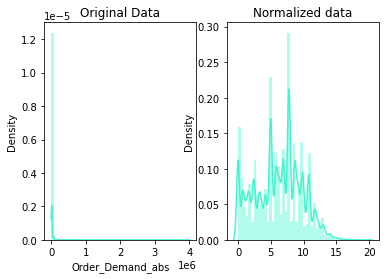

In [31]:
orders = df_cpy['Order_Demand_abs']

pos_orders = orders[orders > 0]

# Normalize the pledges using Box-Cox
normalized_orders = stats.boxcox(pos_orders)[0]

# plot both together to compare

fig, ax=plt.subplots(1,2)
sns.distplot(orders, ax=ax[0], color = "#42f5ce")
ax[0].set_title("Original Data")
sns.distplot(normalized_orders, ax=ax[1], color = "#42f5ce")
ax[1].set_title("Normalized data")

[Text(0.5, 0, 'Normalized Order Demand ')]

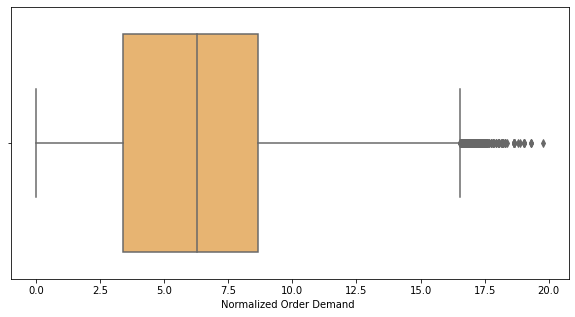

In [32]:
plt.figure(figsize = (10, 5))
sns.boxplot(normalized_orders,color='#fab75f').set(xlabel='Normalized Order Demand ')

In [33]:
data = df_cpy['Order_Demand_abs']
# First quartile (Q1)
Q1 = np.percentile(data, 25, interpolation = 'midpoint')  
# Third quartile (Q3)
Q3 = np.percentile(data, 75, interpolation = 'midpoint')  
# Interquaritle range (IQR)
IQR = Q3 - Q1
  
print(IQR)

1980.0


In [34]:
print("Maximum value for the Order demand i.e Q3 + 3*IQR : ",Q3+3*IQR)
print("Minimum value for the Order demand i.e Q1 - 3*IQR : ",Q1-3*IQR)

Maximum value for the Order demand i.e Q3 + 3*IQR :  7940.0
Minimum value for the Order demand i.e Q1 - 3*IQR :  -5920.0


In [35]:
print("No. of high valued outliers :", len(df_cpy[(df_cpy['Order_Demand_abs'] > 7940) ] ))
print( "Percentage of data that belong to high valued outliers : " , round(len(df_cpy[(df_cpy['Order_Demand_abs'] > 7940) ])*100/len(df_cpy)),"%")

No. of high valued outliers : 126154
Percentage of data that belong to high valued outliers :  12 %


Removing these 12% outliers from the dataset


In [36]:
new_df = df_cpy[(df_cpy['Order_Demand_abs'] < 7940)]
new_df.shape

(922420, 6)

In [37]:
### Extract month, year, quarter , weekday and day from date
new_df['Day'] =  new_df['Date'].dt.day
new_df['Month'] =  new_df['Date'].dt.month
new_df['Month_name'] =  new_df['Date'].dt.strftime('%B')
new_df['Year'] =  new_df['Date'].dt.year
new_df["Quarter"] = new_df['Date'].dt.quarter
new_df["DayOfWeek"] = new_df["Date"].dt.weekday
new_df["IsWeekend"] = new_df["DayOfWeek"] >= 5
### Adding order to month names
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
new_df['Month_name'] = pd.Categorical(new_df['Month_name'], categories= months , ordered=True)

#### Distribution of orders by month

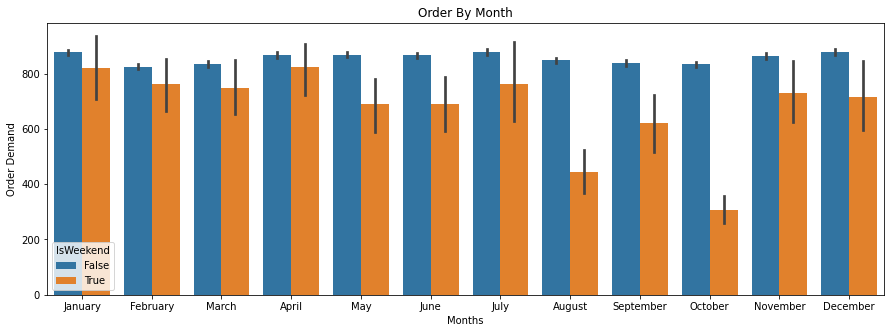

In [38]:
plt.figure(figsize = (15, 5))

ax = sns.barplot(x=new_df.Month_name, y=new_df.Order_Demand_abs, hue=new_df.IsWeekend)
ax.set_title("Order By Month")
ax.set_ylabel("Order Demand")
ax.set_xlabel("Months")

plt.show()

We had observed that the order demands were more during weekend and less during weekdays, however after removing the outliers this has changed.

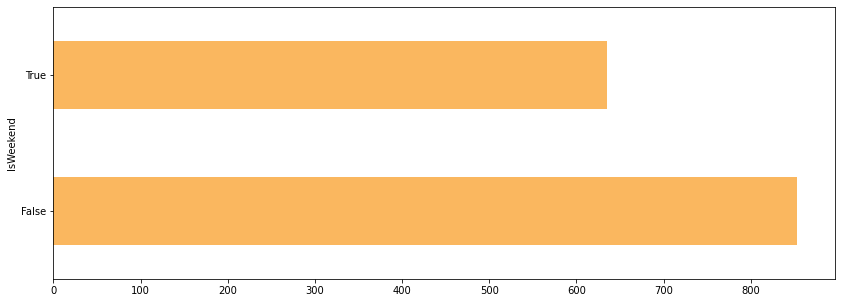

In [39]:
plt.figure(figsize = (14, 5))
new_df.groupby("IsWeekend")['Order_Demand_abs'].mean().plot.barh(color = "#fab75f")

###### ***This means that large quantity of  orders are placed during the weekend***